### Double Descent
- The phenomenon arises when model complexity grows toward the interpolation threshold $p = n$.
- After an initial descent in error, as complexity increases and $p \approx n$, error spikes.
- A second descent follows at higher complexity $p \gg n$, reducing error again.
- Example: polynomial regression with degree $d$ or neural nets with parameter count $p$; once $d>n$ or $p>n$, test error may improve again despite overfitting concerns.


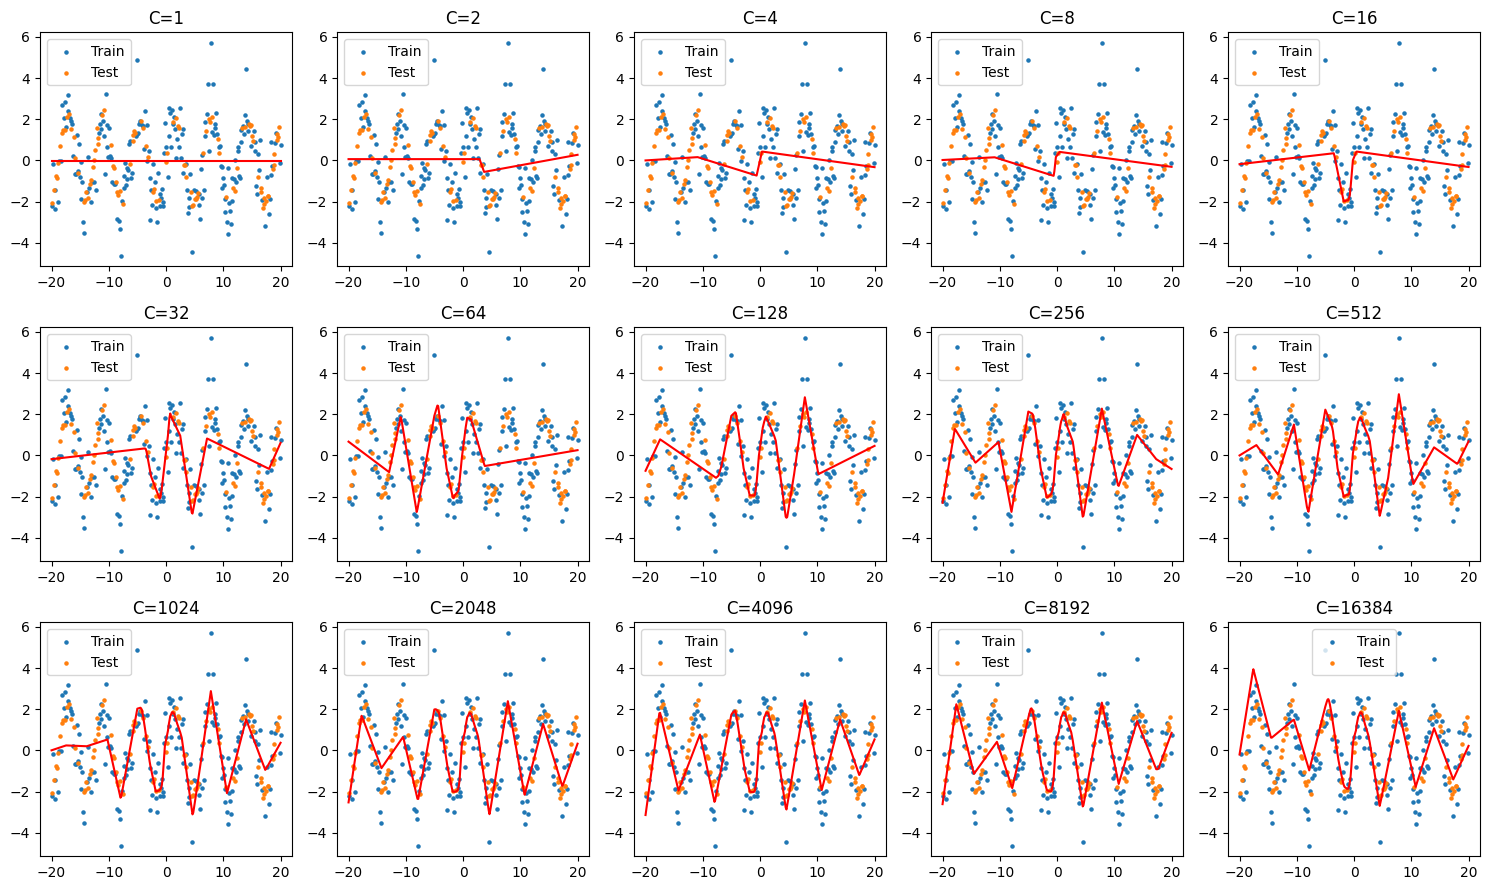

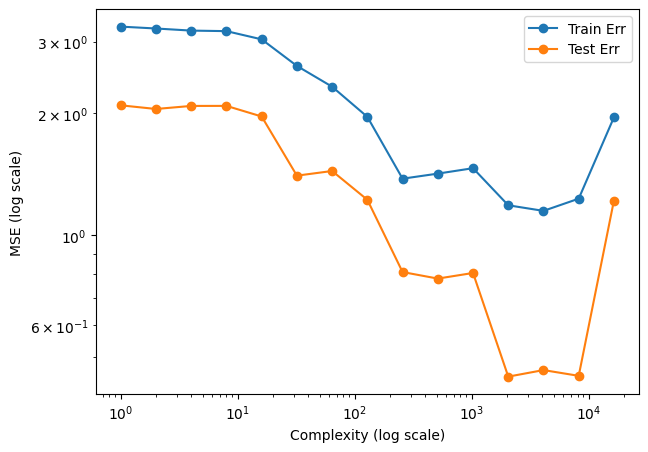

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
x_full = torch.linspace(-20,20,300).reshape(-1,1)
y_full = torch.sin(x_full)*2 + 0.2*torch.randn_like(x_full)
idx = torch.randperm(len(x_full))
train_idx = idx[:200]
test_idx = idx[200:]
x_train, y_train = x_full[train_idx], y_full[train_idx]
x_test, y_test = x_full[test_idx], y_full[test_idx]

y_train += 1.0 * torch.randn_like(y_train)

complexities = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096, 4096*2, 4096*4]
train_err, test_err, preds = [], [], []

for c in complexities:
    model = nn.Sequential(nn.Linear(1,c), nn.ReLU(), nn.Linear(c,1))
    opt = optim.Adam(model.parameters(), lr=0.001)
    for _ in range(10_000):
        loss = ((model(x_train) - y_train)**2).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
    train_err.append(((model(x_train) - y_train)**2).mean().item())
    test_err.append(((model(x_test) - y_test)**2).mean().item())
    preds.append(model(x_full).detach().numpy())

cols = 5
rows = len(complexities)//cols + (1 if len(complexities)%cols else 0)
fig, axs = plt.subplots(rows, cols, figsize=(15, 3*rows))
axs = axs.flatten()

for i, c in enumerate(complexities):
    axs[i].scatter(x_train, y_train, s=5, label='Train')
    axs[i].scatter(x_test, y_test, s=5, label='Test')
    axs[i].plot(x_full, preds[i], color='red')
    axs[i].set_title(f'C={c}')
    axs[i].legend()

for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(complexities, train_err, marker='o', label='Train Err')
plt.plot(complexities, test_err, marker='o', label='Test Err')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Complexity (log scale)')
plt.ylabel('MSE (log scale)')
plt.show()


In [13]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network class
class Net(nn.Module):
    def __init__(self, layer_list):
        super().__init__()
        prev = 28 * 28  # MNIST input dimension
        self.layers = nn.ModuleList([nn.Linear(prev, size) for size in layer_list])
        self.relu = nn.ReLU()
        self.final_layer = nn.Linear(layer_list[-1], 10)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = x.view((x.shape[0], -1))
        for layer in self.layers:
            x = self.relu(layer(x))
        return self.log_softmax(self.final_layer(x))

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = data_utils.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = data_utils.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Training and testing functions
def train(model, loss_fn, optimizer, train_loader):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

def test(model, loss_fn, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.1f}%")
    return 1 - accuracy / 100  # Error rate

# Main loop to observe double descent
layer_list = [25] * 6
results = []

for i in range(50):
    layer_list = [size + 10 for size in layer_list]
    model = Net(layer_list)
    optimizer = opt.SGD(model.parameters(), lr=0.1, momentum=0.9)
    loss_fn = nn.NLLLoss()

    # Train and evaluate the model
    train(model, loss_fn, optimizer, train_loader)
    error_rate = test(model, loss_fn, test_loader)
    results.append((sum(layer_list), error_rate))

# Plot the results
hidden_units, error_rates = zip(*results)
plt.plot(hidden_units, error_rates, marker='o')
plt.xlabel("Total Hidden Units")
plt.ylabel("Error Rate")
plt.title("Double Descent Phenomenon")
plt.show()


AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [11]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 23.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 23.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
